# Feature Selection/Importance

This notebook will be a part of **Feature Selection** node of the Klee project.
Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data when creating a predictive model. It helps you estimate how much each feature of your data contributed to the model’s prediction. After performing feature importance tests, you can figure out which features are making the most impact on your model’s decision making. This can improve model performance significantly.
- The performance significantly drops once the number of features start to add-up
- Unsupervised feature selection techniques ignores the target variable, such as methods that remove redundant variables using correlation. 
- Supervised feature selection techniques use the target variable, such as methods that remove irrelevant variables..

### Methods used for Feature Selection:
- Spearson Correlation
- Backward Elimination
- Recursive Feature Elimination 
- Regularization
- ExtraTreeRegressor
- XGBoost
- Permutation based Feature Importance
- SHAP values for feature selection

### Libraries used 
- We use ``ScikitLearn``, ``XgBoost``and ``SHAP`` to investigate and select best features from the dataset. 

#### Input: 
The input to this notebook is Tabular dataset. Ex. Boston Housing dataset used in this notebook

#### Output:
Output of this notebook is best features selected from the dataset.

### Difference of SHAP vs Other feature selection methods(sklearn, statsmodel etc)
 This method is considered somewhat better than the traditional sckit-learn methods because many of these methods can be inconsistent, which means that the features that are most important may not always be given the highest feature importance score. **One example** is that in the tree-based models which might give two equally important features different scores based on what level of splitting was done using the features. The features which split the model first might be given higher importance. This is the motivation for using the latest feature attribution method, Shapley Additive Explanations.
- SHAP: Fairly share the interaction effects effects
- SHAP works better for complex models
- SHAP is independent of models

In [1]:
# Imports

import shap
import numpy  as np
import pandas as pd 
import lightgbm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,train_test_split, cross_val_score
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE
from xgboost import XGBRegressor, plot_importance
from sklearn.inspection import permutation_importance
from sklearn.datasets   import load_boston
from sklearn.ensemble   import RandomForestRegressor,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import sklearn
import seaborn as sns

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
# load the data

boston = load_boston()

# Create a Pandas dataframe with all the features
X = pd.DataFrame(data = boston['data'], columns = boston['feature_names'])
y = boston['target']

In [3]:
# train test split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [13]:
# this returns F-Statistics for each feature and p-Value for each feature
# The default value for center is True; center = False, if the data is not standardized
sklearn.feature_selection.f_regression(pd.DataFrame(X),pd.DataFrame(y,columns=["Target"]), center= False)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(array([  26.62540066,  195.45052484,  466.32476415,   52.69159411,
        1625.59896904, 4614.51617836,  915.08377313, 1380.03353065,
         266.19556075,  830.46909616, 2088.32536097, 3147.779779  ,
         410.9323784 ]),
 array([3.55554392e-007, 8.87823995e-038, 9.55082965e-074, 1.48290625e-012,
        5.53284345e-160, 3.74375819e-256, 1.84855050e-115, 1.51525782e-146,
        2.24637612e-048, 1.02622585e-108, 1.51036031e-181, 3.98926958e-219,
        2.71419481e-067]))

#### Spearson Correlation

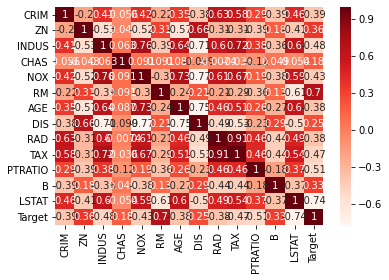

In [4]:
cor = pd.concat([pd.DataFrame(X),pd.DataFrame(y,columns=["Target"])],axis=1).corr(method="pearson")
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [27]:
cor_target = abs(cor["Target"])

## Selecting highly correlated features
## we select features with a Pearson correlation value higher than 0.4

relevant_features = cor_target[cor_target>0.4]
relevant_features

INDUS      0.483725
NOX        0.427321
RM         0.695360
TAX        0.468536
PTRATIO    0.507787
LSTAT      0.737663
Target     1.000000
Name: Target, dtype: float64

### Backward Elimination
As the name suggest, we feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range. The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.


In [30]:
## Backward Elimination

X_1 = sm.add_constant(pd.DataFrame(X))
#Fitting sm.OLS model
model = sm.OLS(pd.DataFrame(y,columns=["Target"]),X_1).fit()
model.pvalues

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

In [36]:
#Backward Elimination

X=pd.DataFrame(X)
y=pd.DataFrame(y,columns=["Target"])
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
print("Selected_features are : " , cols)

Selected_features are :  ['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


> the above method removes 2 features and keeps 11 features as important

#### Recursive Feature Elimination

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.


In [54]:


model = sklearn.linear_model.LinearRegression()

#Initializing RFE model
rfe = RFE(model, 10)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False  True  True False  True False
  True]
[1 1 1 1 1 1 4 1 1 2 1 3 1]


Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


In [53]:
#no of features
nof_list=np.arange(1,len(X.columns))            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = sklearn.linear_model.LinearRegression()
    rfe = RFE(model,nof_list[n])
    print(n,",",rfe)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
#     print(X_train_rfe)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    print("Score : ", score)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("-"*30)
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

0 , RFE(estimator=LinearRegression(), n_features_to_select=1)
Score :  0.17771860345328638
1 , RFE(estimator=LinearRegression(), n_features_to_select=2)
Score :  0.4746832940559722
2 , RFE(estimator=LinearRegression(), n_features_to_select=3)
Score :  0.5083778622385811
3 , RFE(estimator=LinearRegression(), n_features_to_select=4)
Score :  0.5050323653332087
4 , RFE(estimator=LinearRegression(), n_features_to_select=5)
Score :  0.5359834100900923
5 , RFE(estimator=LinearRegression(), n_features_to_select=6)
Score :  0.6407589788474839
6 , RFE(estimator=LinearRegression(), n_features_to_select=7)
Score :  0.6393236650194686
7 , RFE(estimator=LinearRegression(), n_features_to_select=8)
Score :  0.6486307219922898
8 , RFE(estimator=LinearRegression(), n_features_to_select=9)
Score :  0.653278493584889
9 , RFE(estimator=LinearRegression(), n_features_to_select=10)
Score :  0.6635808601043212
10 , RFE(estimator=LinearRegression(), n_features_to_select=11)
Score :  0.6618875151534966
11 , RF

Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
Pass n_features_to_select=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
Pass n_features_to_select=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error

> from the results above we can conclude that 10 features are optimal for the performance

In [56]:
cols = list(X.columns)
model = sklearn.linear_model.LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


### Regularization
Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

In [58]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [61]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

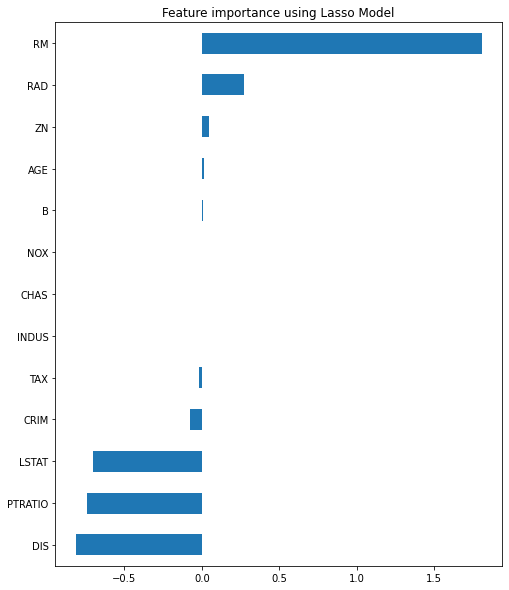

In [60]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

> Lasso model has taken all the features except NOX, CHAS and INDUS.

### Extra Tree Regressor
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

In [75]:
model = ExtraTreesRegressor()
model.fit(X, y.values)
print(model.feature_importances_)

[0.03224181 0.00381948 0.04304586 0.01401426 0.03958015 0.33488884
 0.02147752 0.03204674 0.02192414 0.03449153 0.05314318 0.01792214
 0.35140435]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [87]:
pd.concat([pd.DataFrame(X.columns,columns=["Feature"]),pd.DataFrame(model.feature_importances_,columns=["FeatureImportance"])],axis=1)

,Feature,FeatureImportance
0,CRIM,0.032242
1,ZN,0.003819
2,INDUS,0.043046
3,CHAS,0.014014
4,NOX,0.039580
5,RM,0.334889
6,AGE,0.021478
7,DIS,0.032047
8,RAD,0.021924
9,TAX,0.034492


### XGBoost : built-in feature importance
There are several types of importance in the Xgboost - it can be computed in several different ways. The default type is "Gain"- if you construct model with scikit-learn like API (docs). When you access Booster object and get the importance with get_score method, then default is "weight". You can check the type of the importance with xgb.importance_type.
https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [5]:
# XGBoost

xgb = XGBRegressor(n_estimators=100)
xgb.fit(Xtrain, ytrain)

[18:34:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Text(0.5, 0, 'Xgboost Feature Importance')

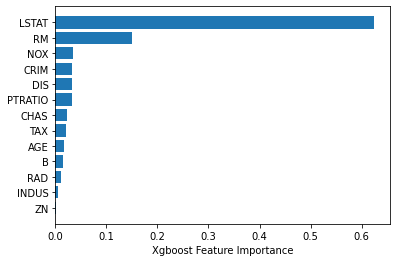

In [8]:
# XGBoost Feature importance

"""
There are several types of importance in the Xgboost - it can be computed in several different ways. 
The default type is gain if you construct model with scikit-learn
"""

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [7]:
xgbDF = pd.DataFrame()
xgbDF["Features"] = boston.feature_names[sorted_idx]
xgbDF["XGBValue"] = xgb.feature_importances_[sorted_idx]

xgbDF

,Features,XGBValue
0,ZN,0.001418
1,INDUS,0.004803
2,RAD,0.011492
3,B,0.015350
4,AGE,0.016177
5,TAX,0.020334
6,CHAS,0.023051
7,PTRATIO,0.031846
8,DIS,0.032306
9,CRIM,0.032970


In [ ]:
# setting up a threshold of 0.05

xgbDF.Features[xgbDF['XGBValue'] >= 0.05].tolist() 

#### Permutation based importance
Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

Text(0.5, 0, 'Permutation Importance')

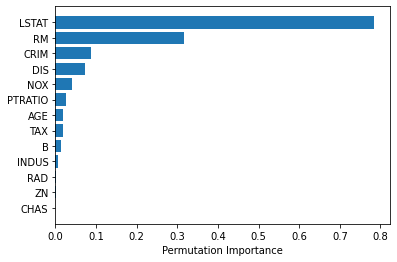

In [187]:
# sklearn feature importance

"""
This permutation method will randomly shuffle each feature and compute the change in the model’s performance. 
The features which impact the performance the most are the most important one.
"""

perm_importance = permutation_importance(xgb, Xtest, ytest)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [134]:
sklearnDF = pd.DataFrame()
sklearnDF["Features"] = boston.feature_names[sorted_idx]
sklearnDF["SKlearnValue"] = perm_importance.importances_mean[sorted_idx]

sklearnDF

,Features,SKlearnValue
0,ZN,-0.000164
1,RAD,0.002060
2,B,0.002175
3,INDUS,0.002758
4,CHAS,0.004457
5,TAX,0.006927
6,AGE,0.016569
7,PTRATIO,0.018749
8,NOX,0.027139
9,CRIM,0.031220


### SHAP: Feature Importance computed with SHAP values
The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Next, we sort the features by decreasing importance and plot them.
- Shap vs Permutation based feature importance:\
SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.The feature importance plot is useful, but contains no information beyond the importances
- The 2 methods in SHAP:
- Local feature importance calculates the importance of each feature for each data point. 
- A global measure refers to a single ranking of all features for the model
> ex. Local feature importance becomes relevant in certain cases as well, like, loan application where each data point is an individual person to ensure fairness and equity. I can also think of a hybrid example, like, credit card fraud detection where each person has multiple transactions. While each person will have a different feature importance ranking, there needs to be a global measure for all transactions to detect outliers in the transactions.  You can get the global measure by aggregating the local feature importances for each data point.

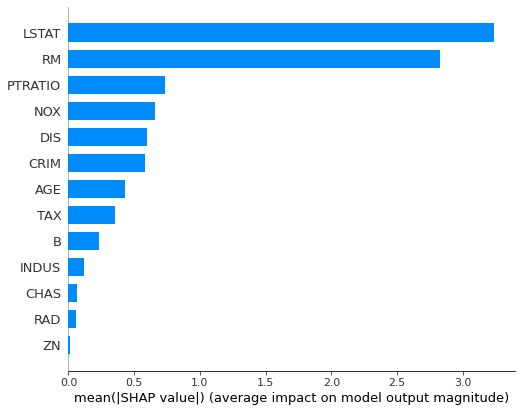

In [135]:
# feature importance with SHAP

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(Xtest)

shap.summary_plot(shap_values, Xtest, plot_type="bar")

In [136]:
vals= np.abs(shap_values).mean(0)
shapDF = pd.DataFrame(list(zip(Xtrain.columns,vals)),columns=['Features','ShapValue'])
shapDF.sort_values(by=['ShapValue'],ascending=False,inplace=True)
shapDF

,Features,ShapValue
12,LSTAT,3.234388
5,RM,2.825006
10,PTRATIO,0.733931
4,NOX,0.661812
7,DIS,0.596655
0,CRIM,0.579279
6,AGE,0.432407
9,TAX,0.355390
11,B,0.235203
2,INDUS,0.115584


In [137]:
ex1 = xgbDF.merge(sklearnDF, left_on='Features', right_on='Features')
ex1 = ex1.merge(shapDF, left_on='Features', right_on='Features')
ex1

,Features,XGBValue,SKlearnValue,ShapValue
0,ZN,0.005897,-0.000164,0.012152
1,CHAS,0.010067,0.004457,0.065484
2,INDUS,0.010297,0.002758,0.115584
3,AGE,0.016225,0.016569,0.432407
4,RAD,0.018450,0.002060,0.059710
5,B,0.020452,0.002175,0.235203
6,DIS,0.020600,0.079580,0.596655
7,TAX,0.031069,0.006927,0.355390
8,CRIM,0.043586,0.031220,0.579279
9,NOX,0.058273,0.027139,0.661812


# Next steps after feature importance plots

#### Feature scaling/Data Normalization

In [138]:
xgbmax = ex1["XGBValue"].max()
xgbmin = ex1["XGBValue"].min()
ex1["RescaledXGB"] = ex1["XGBValue"].apply(lambda x : (x - xgbmin)/(xgbmax - xgbmin) )

skmax = ex1["SKlearnValue"].max()
skmin = ex1["SKlearnValue"].min()
ex1["RescaledSKLearn"] = ex1["SKlearnValue"].apply(lambda x : (x - skmin)/(skmax - skmin) )

shapmax = ex1["ShapValue"].max()
shapmin = ex1["ShapValue"].min()
ex1["RescaledShap"] = ex1["ShapValue"].apply(lambda x : (x - shapmin)/(shapmax - shapmin) )

ex1

,Features,XGBValue,SKlearnValue,ShapValue,RescaledXGB,RescaledSKLearn,RescaledShap
0,ZN,0.005897,-0.000164,0.012152,0.000000,0.000000,0.000000
1,CHAS,0.010067,0.004457,0.065484,0.012020,0.010004,0.016551
2,INDUS,0.010297,0.002758,0.115584,0.012682,0.006327,0.032099
3,AGE,0.016225,0.016569,0.432407,0.029770,0.036224,0.130423
4,RAD,0.018450,0.002060,0.059710,0.036182,0.004814,0.014759
5,B,0.020452,0.002175,0.235203,0.041950,0.005063,0.069222
6,DIS,0.020600,0.079580,0.596655,0.042376,0.172632,0.181397
7,TAX,0.031069,0.006927,0.355390,0.072552,0.015352,0.106521
8,CRIM,0.043586,0.031220,0.579279,0.108626,0.067941,0.176004
9,NOX,0.058273,0.027139,0.661812,0.150956,0.059106,0.201618


In [139]:
WithoutHT = ex1[["Features","RescaledXGB", "RescaledSKLearn","RescaledShap"]]
WithoutHT

,Features,RescaledXGB,RescaledSKLearn,RescaledShap
0,ZN,0.000000,0.000000,0.000000
1,CHAS,0.012020,0.010004,0.016551
2,INDUS,0.012682,0.006327,0.032099
3,AGE,0.029770,0.036224,0.130423
4,RAD,0.036182,0.004814,0.014759
5,B,0.041950,0.005063,0.069222
6,DIS,0.042376,0.172632,0.181397
7,TAX,0.072552,0.015352,0.106521
8,CRIM,0.108626,0.067941,0.176004
9,NOX,0.150956,0.059106,0.201618


In [176]:
def topXFeatures(n):
    a = WithoutHT.sort_values('RescaledXGB',ascending=False).head(n).Features.tolist()
    b = WithoutHT.sort_values('RescaledSKLearn',ascending=False).head(n).Features.tolist()
    c = WithoutHT.sort_values('RescaledShap',ascending=False).head(n).Features.tolist()
    print( "top features with inbuilt", a)
    print( "top features with Sklearn",b)
    print( "top features with shap",c)
    
    commonfeatures = set(a).intersection(set(b)).intersection(set(c))
    print("Common Features : ",len(commonfeatures), "->",commonfeatures)
    
topXFeatures(8)

top features with inbuilt ['RM', 'LSTAT', 'PTRATIO', 'NOX', 'CRIM', 'TAX', 'DIS', 'B']
top features with Sklearn ['LSTAT', 'RM', 'DIS', 'CRIM', 'NOX', 'PTRATIO', 'AGE', 'TAX']
top features with shap ['LSTAT', 'RM', 'PTRATIO', 'NOX', 'DIS', 'CRIM', 'AGE', 'TAX']
Common Features :  7 -> {'PTRATIO', 'DIS', 'LSTAT', 'NOX', 'RM', 'TAX', 'CRIM'}


#### Hyperparameter Tuning with Feature Selection

Model used: XGBoost with RandomizedSearchCV

In [140]:
xgb = XGBRegressor()

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [141]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv= 5 ,verbose=3, random_state=1001 )

random_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[12:03:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, verbose=3)

In [142]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

In [143]:
print("Train Score: ", random_search.best_estimator_.score(Xtrain,ytrain))
print("Test Score: ", random_search.best_estimator_.score(Xtest,ytest))

Train Score:  0.9925059202356921
Test Score:  0.8195025092644956


In [144]:
#training with best parameters

xgb_best = XGBRegressor(subsample= 0.8, min_child_weight= 1,
 max_depth= 4, gamma= 1, colsample_bytree = 1.0)
xgb_best.fit( Xtrain, ytrain)

[12:03:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=1.0, gamma=1, max_depth=4, subsample=0.8)

In [145]:
xgb_best.score(Xtest,ytest)

0.8277951954633155

,Features,XGBValue
0,CHAS,0.008470
1,ZN,0.008968
2,AGE,0.014487
3,B,0.016760
4,INDUS,0.018328
5,RAD,0.023775
6,DIS,0.024711
7,TAX,0.034803
8,CRIM,0.041572
9,PTRATIO,0.047364


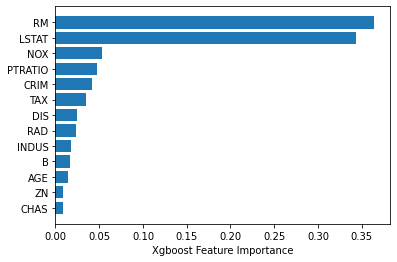

In [146]:
# XGBoost Feature importance

"""
There are several types of importance in the Xgboost - it can be computed in several different ways. 
The default type is gain if you construct model with scikit-learn
"""

sorted_idx = xgb_best.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_idx], xgb_best.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")


xgbDF = pd.DataFrame()
xgbDF["Features"] = boston.feature_names[sorted_idx]
xgbDF["XGBValue"] = xgb_best.feature_importances_[sorted_idx]

xgbDF

,Features,SKlearnValue
0,ZN,-0.000545
1,CHAS,0.000539
2,RAD,0.000859
3,INDUS,0.002663
4,TAX,0.007578
5,AGE,0.007955
6,B,0.014554
7,NOX,0.016822
8,PTRATIO,0.017387
9,CRIM,0.062152


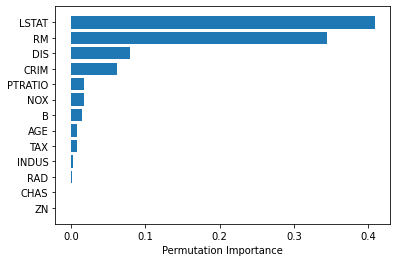

In [147]:
# sklearn feature importance

"""
This permutation method will randomly shuffle each feature and compute the change in the model’s performance. 
The features which impact the performance the most are the most important one.
"""

perm_importance = permutation_importance(xgb_best, Xtest, ytest)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

sklearnDF = pd.DataFrame()
sklearnDF["Features"] = boston.feature_names[sorted_idx]
sklearnDF["SKlearnValue"] = perm_importance.importances_mean[sorted_idx]

sklearnDF

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


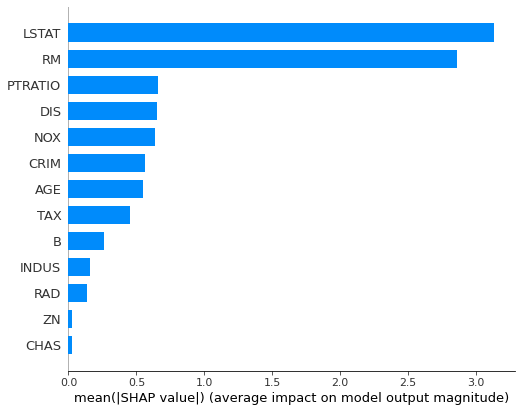

,Features,ShapValue
12,LSTAT,3.127965
5,RM,2.857797
10,PTRATIO,0.656369
7,DIS,0.648174
4,NOX,0.639669
0,CRIM,0.562399
6,AGE,0.549585
9,TAX,0.451629
11,B,0.259254
2,INDUS,0.155998


In [148]:
# feature importance with SHAP

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(Xtest)

shap.summary_plot(shap_values, Xtest, plot_type="bar")


vals= np.abs(shap_values).mean(0)
shapDF = pd.DataFrame(list(zip(Xtrain.columns,vals)),columns=['Features','ShapValue'])
shapDF.sort_values(by=['ShapValue'],ascending=False,inplace=True)
shapDF

In [152]:
ex2=pd.DataFrame()
ex2 = xgbDF.merge(sklearnDF, left_on='Features', right_on='Features')
ex2 = ex2.merge(shapDF, left_on='Features', right_on='Features')
ex2

xgbmax = ex2["XGBValue"].max()
xgbmin = ex2["XGBValue"].min()
ex2["RescaledXGB"] = ex2["XGBValue"].apply(lambda x : (x - xgbmin)/(xgbmax - xgbmin) )

skmax = ex2["SKlearnValue"].max()
skmin = ex2["SKlearnValue"].min()
ex2["RescaledSKLearn"] = ex2["SKlearnValue"].apply(lambda x : (x - skmin)/(skmax - skmin) )

shapmax = ex2["ShapValue"].max()
shapmin = ex2["ShapValue"].min()
ex2["RescaledShap"] = ex2["ShapValue"].apply(lambda x : (x - shapmin)/(shapmax - shapmin) )

withHT = ex2[["Features","RescaledXGB","RescaledSKLearn","RescaledShap"]]
withHT

,Features,RescaledXGB,RescaledSKLearn,RescaledShap
0,CHAS,0.000000,0.002647,0.000000
1,ZN,0.001401,0.000000,0.001821
2,AGE,0.016910,0.020764,0.169725
3,B,0.023298,0.036885,0.076235
4,INDUS,0.027706,0.007835,0.042985
5,RAD,0.043012,0.003429,0.035797
6,DIS,0.045641,0.196108,0.201473
7,TAX,0.074004,0.019844,0.138182
8,CRIM,0.093027,0.153162,0.173852
9,PTRATIO,0.109305,0.043806,0.204112


In [160]:
# comparison of with and without HT


mergeddf = withHT.merge(WithoutHT, on="Features")
mergeddf["DiffXGB"]     = round(mergeddf["RescaledXGB_y"] - mergeddf["RescaledXGB_x"] ,2)*100
mergeddf["DiffSKlearn"] = round(mergeddf["RescaledSKLearn_y"] - mergeddf["RescaledSKLearn_x"] ,2)*100
mergeddf["DiffShap"]    = round(mergeddf["RescaledShap_y"] - mergeddf["RescaledShap_x"] ,2)*100

mergeddf[["Features","RescaledXGB_x","RescaledXGB_y","DiffXGB","RescaledSKLearn_x","RescaledSKLearn_y","DiffSKlearn","RescaledShap_x","RescaledShap_y","DiffShap"]]

,Features,RescaledXGB_x,RescaledXGB_y,DiffXGB,RescaledSKLearn_x,RescaledSKLearn_y,DiffSKlearn,RescaledShap_x,RescaledShap_y,DiffShap
0,CHAS,0.000000,0.012020,1.0,0.002647,0.010004,1.0,0.000000,0.016551,2.0
1,ZN,0.001401,0.000000,-0.0,0.000000,0.000000,0.0,0.001821,0.000000,-0.0
2,AGE,0.016910,0.029770,1.0,0.020764,0.036224,2.0,0.169725,0.130423,-4.0
3,B,0.023298,0.041950,2.0,0.036885,0.005063,-3.0,0.076235,0.069222,-1.0
4,INDUS,0.027706,0.012682,-2.0,0.007835,0.006327,-0.0,0.042985,0.032099,-1.0
5,RAD,0.043012,0.036182,-1.0,0.003429,0.004814,0.0,0.035797,0.014759,-2.0
6,DIS,0.045641,0.042376,-0.0,0.196108,0.172632,-2.0,0.201473,0.181397,-2.0
7,TAX,0.074004,0.072552,-0.0,0.019844,0.015352,-0.0,0.138182,0.106521,-3.0
8,CRIM,0.093027,0.108626,2.0,0.153162,0.067941,-9.0,0.173852,0.176004,0.0
9,PTRATIO,0.109305,0.169228,6.0,0.043806,0.040943,-0.0,0.204112,0.223999,2.0


# Conclusion:
Hyperparameter creates a significant different in the feature selection method

### Feature Selection with Other Models:
Models used: RandomForest, LightGBM

#### RandomForest

In [ ]:
# Modeling
# Random Forest Regressor

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(Xtrain, ytrain)

rf_train = rf_reg.score(Xtrain, ytrain)
rf_cv = cross_val_score(rf_reg, Xtrain, ytrain, cv=5).mean()
rf_test = rf_reg.score(Xtest, ytest)

# Results
print('Evaluation of the Random Forest performance\n')
print(f'Training score: {rf_train.round(4)}')
print(f'Cross validation score: {rf_cv.round(4)}')
print(f'Test score: {rf_test.round(4)}')

In [106]:
def featureComparison(model,Xtest,ytest):
    "Compare feature importance using different methods for XGB Model"
    
    # Feature importance of XGBoost inbuilt function
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(boston.feature_names[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance")
    
    xgbDF = pd.DataFrame()
    xgbDF["Features"] = boston.feature_names[sorted_idx]
    xgbDF["XGBValue"] = model.feature_importances_[sorted_idx]
    
    #Feature Importance with SKLearn

    perm_importance = permutation_importance(model, Xtest, ytest)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

    sklearnDF = pd.DataFrame()
    sklearnDF["Features"] = boston.feature_names[sorted_idx]
    sklearnDF["SKlearnValue"] = perm_importance.importances_mean[sorted_idx]
    print(sklearnDF)
    # feature importance with SHAP

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(Xtest)
    shap.summary_plot(shap_values, Xtest, plot_type="bar")

    vals= np.abs(shap_values).mean(0)
    shapDF = pd.DataFrame(list(zip(Xtrain.columns,vals)),columns=['Features','ShapValue'])
    shapDF.sort_values(by=['ShapValue'],ascending=False,inplace=True)

    # Feature Normalization
    df = pd.DataFrame()
    df = xgbDF.merge(sklearnDF, left_on='Features', right_on='Features')
    df = df.merge(shapDF, left_on='Features', right_on='Features')
        
    xgbmax = df["XGBValue"].max()
    xgbmin = df["XGBValue"].min()
    df["RescaledXGB"] = df["XGBValue"].apply(lambda x : (x - xgbmin)/(xgbmax - xgbmin) )

    skmax = df["SKlearnValue"].max()
    skmin = df["SKlearnValue"].min()
    df["RescaledSKLearn"] = df["SKlearnValue"].apply(lambda x : (x - skmin)/(skmax - skmin) )

    shapmax = df["ShapValue"].max()
    shapmin = df["ShapValue"].min()
    df["RescaledShap"] = df["ShapValue"].apply(lambda x : (x - shapmin)/(shapmax - shapmin) )

    return df[["Features","RescaledXGB","RescaledSKLearn","RescaledShap"]]

   Features  SKlearnValue
0        ZN     -0.000038
1      CHAS      0.000624
2     INDUS      0.002622
3       RAD      0.003255
4       TAX      0.008818
5       AGE      0.014449
6   PTRATIO      0.014450
7         B      0.017575
8       NOX      0.033787
9      CRIM      0.042810
10      DIS      0.145174
11       RM      0.418923
12    LSTAT      0.723929


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


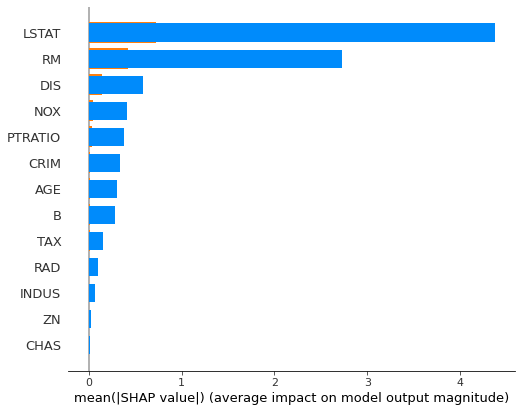

,Features,RescaledXGB,RescaledSKLearn,RescaledShap
0,ZN,0.000000,0.000000,0.002241
1,CHAS,0.001265,0.000915,0.000000
2,INDUS,0.006551,0.003675,0.012623
3,RAD,0.010115,0.004549,0.019879
4,TAX,0.019851,0.012233,0.031983
5,PTRATIO,0.034127,0.020013,0.084105
6,AGE,0.034532,0.020012,0.066082
7,B,0.035032,0.024330,0.062369
8,NOX,0.056102,0.046722,0.090009
9,CRIM,0.067593,0.059185,0.072693


In [177]:
RFResults = featureComparison(rf_reg,Xtest,ytest)
RFResults

## LightGBM 

In [96]:
# Modeling
# Light GBM

gbm = lightgbm.LGBMRegressor()
gbm.fit(Xtrain,ytrain)

print("Train score: ", gbm.score(Xtrain,ytrain))
print("Test score: ", gbm.score(Xtest,ytest))


Train score:  0.9754117761347518
Test score:  0.9021659136654173


   Features  SKlearnValue
0        ZN      0.000139
1      CHAS      0.002450
2     INDUS      0.004012
3       RAD      0.005438
4       TAX      0.007124
5   PTRATIO      0.012988
6      CRIM      0.020301
7         B      0.027820
8       AGE      0.033599
9       NOX      0.043970
10      DIS      0.089379
11       RM      0.249041
12    LSTAT      0.688208


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


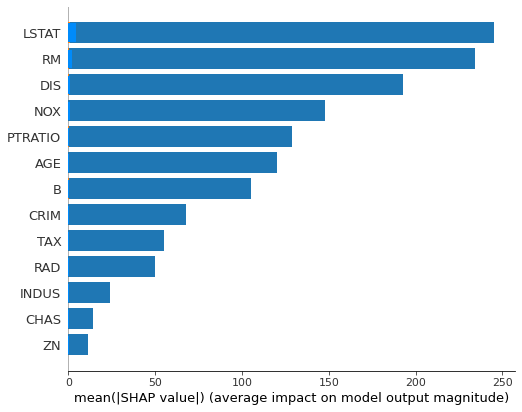

,Features,RescaledXGB,RescaledSKLearn,RescaledShap
0,ZN,0.000000,0.000000,0.000000
1,CHAS,0.012821,0.003357,0.012159
2,RAD,0.055556,0.007701,0.034578
3,INDUS,0.166667,0.005628,0.029292
4,TAX,0.188034,0.010151,0.057602
5,PTRATIO,0.243590,0.018674,0.097275
6,NOX,0.401709,0.063701,0.183355
7,B,0.465812,0.040229,0.070702
8,AGE,0.504274,0.048628,0.093692
9,CRIM,0.585470,0.029302,0.067945


In [178]:
GBMResults = featureComparison(gbm,Xtest,ytest)
GBMResults

In [180]:
RFBGM = GBMResults.merge(RFResults,on="Features")
RFBGM[["Features","RescaledXGB_x","RescaledXGB_y","RescaledSKLearn_x","RescaledSKLearn_y","RescaledShap_x","RescaledShap_y"]]

,Features,RescaledXGB_x,RescaledXGB_y,RescaledSKLearn_x,RescaledSKLearn_y,RescaledShap_x,RescaledShap_y
0,ZN,0.000000,0.000000,0.000000,0.000000,0.000000,0.002241
1,CHAS,0.012821,0.001265,0.003357,0.000915,0.012159,0.000000
2,RAD,0.055556,0.010115,0.007701,0.004549,0.034578,0.019879
3,INDUS,0.166667,0.006551,0.005628,0.003675,0.029292,0.012623
4,TAX,0.188034,0.019851,0.010151,0.012233,0.057602,0.031983
5,PTRATIO,0.243590,0.034127,0.018674,0.020013,0.097275,0.084105
6,NOX,0.401709,0.056102,0.063701,0.046722,0.183355,0.090009
7,B,0.465812,0.035032,0.040229,0.024330,0.070702,0.062369
8,AGE,0.504274,0.034532,0.048628,0.020012,0.093692,0.066082
9,CRIM,0.585470,0.067593,0.029302,0.059185,0.067945,0.072693


# Additional experiments

### 3 options for measuring the importance of features

- ***Weight***: 
The number of times a feature is used to split the data across all trees.
- ***Cover*** : 
The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- ***Gain*** (ginni importance): 
The average training loss reduction gained when using a feature for splitting.


- ***Consistency*** : Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
- ***Accuracy*** : The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

# Experiment 

Here we will define importance two ways: 
- as the change in the model’s expected accuracy when we remove a set of features. 
- as the change in the model’s expected output when we remove a set of features.